# TLC AIR Lab Tasks

## Task 1
Daily aggregates of For-Hire trips from NYC Airports (Newark (EWR), John F. Kennedy (JFK), and LaGuardia (LGA)) comparison between Uber, Lyft, Via, Juno, and Other companies. The following is an analysis for the week of January 8th, 2018 12:00AM to January 15th, 2018 12:00AM comparing the total trips, the number of wheelchair accessible (WAV) vehicles, number of battery electric vehicles (BEV), and number of shared rides.

#### Visualizations
For a simple interactive visualization of the aggregated data, we will use altair

In [41]:
import altair as alt
alt.renderers.enable('notebook')

RendererRegistry.enable('notebook')

### Trips for January 8 - 15

First we clean up the trip records for the week of January 8 - 15. After using the filter feature on the NYC Open Data: View Data platform, we exported it to a CSV file. (https://data.cityofnewyork.us/Transportation/2018-For-Hire-Vehicles-Trip-Data/am94-epxh/ data)

In [2]:
import pandas as pd
import numpy as np

In [3]:
trips_raw = pd.read_csv('2018_For_Hire_Vehicles_Trip_Data_filter.csv')

We will only be looking at the trips that started at the NYC airports. (https://data.cityofnewyork.us/Transportation/NYC-Taxi-Zones/d3c5-ddgc)

In [4]:
# EWR, JFK, LGA location ID
airports = [1, 132, 138]

In [5]:
# Filter by airport trips only
trips_airport = trips_raw[trips_raw['PUlocationID'].isin(airports)]

There are duplicate trip records from the same dispatching base number, with the same pick-up time, drop-off time, and drop-off location. Displayed below are the base numbers with the duplicate copies. We will be removing these from the analysis.

In [6]:
trip_duplicates = trips_airport[trips_airport.duplicated(keep=False)]

In [7]:
trip_duplicates['dispatching_base_number'].value_counts()

B02510    1020
B01989       2
B02426       2
Name: dispatching_base_number, dtype: int64

In [8]:
# Filter out all duplicates
trips_airport = trips_airport.drop_duplicates()

In [49]:
len(trips_airport)

105251

#### Clean Up Trips Record

In [50]:
trips_airport['Day'] = pd.DatetimeIndex(trips_airport['Pickup_DateTime']).strftime("%m/%d/%Y")

### Active For-Hire Vehicles

We will clean up the data of active for-hire vehicles. First we will identify the App companies for each corresponding Base Number. Then we will use this data to estimate the number of WAVs adn BEVs. (https://data.cityofnewyork.us/Transportation/For-Hire-Vehicles-FHV-Active/8wbx-tsch)

In [10]:
for_hire_raw = pd.read_csv('For_Hire_Vehicles__FHV__-_Active.csv')

/Users/fannyshum/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3057: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [11]:
for_hire = for_hire_raw[['Vehicle VIN Number', 'Wheelchair Accessible', 'Base Number', 
                         'Base Name', 'VEH', 'Vehicle Year']]

#### Company Function
We will add a column identifying the company App as either Uber, Lyft, Via, Juno, or Other. (http://www.nybcf.org/members)

The formatting of the html was not ideal for extracting the App with the associated Base Number using BeautifulSoup. So we will have it written manually below.

In [12]:
uber = ['B02871', 'B02889', 'B02764', 'B02835', 'B02884', 'B02836', 'B02872', 'B02887', 
       'B02878', 'B02867', 'B02879', 'B02598', 'B02870', 'TNC170002', 'B02682', 'B02875', 
       'B02883', 'B02864', 'B02865', 'B02876', 'B02869', 'B02882', 'B02866', 'B02877']
lyft = ['TNC170001', 'B02510']
via = ['B02800']
juno = ['B02914']

In [13]:
# define function to label company
def company(base_num):
    if base_num in uber:
        return 'Uber'
    elif base_num in lyft:
        return 'Lyft'
    elif base_num in via:
        return 'Via'
    elif base_num in juno:
        return 'Juno'
    return 'Other'

In [14]:
for_hire['App'] = for_hire.apply(lambda row: company(row['Base Number']), axis =1)

/Users/fannyshum/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


#### Total Vehicles by App

In [43]:
for_hire_Ct = for_hire[['App', 'Base Number', 'Vehicle VIN Number']]

In [44]:
for_hire_Ct = for_hire_Ct.groupby(['App', 'Base Number']).count()
for_hire_Ct = for_hire_Ct.reset_index()
for_hire_Ct.columns = ['App', 'Base Number', 'Total Vehicles']

#### Dataframe of Base Number and Company

In [29]:
for_hire_app = for_hire[['Base Number', 'App']]

In [30]:
for_hire_app = for_hire_app.drop_duplicates()

#### Reduce For-Hire to the Base Numbers shown in the trips record

In [15]:
trips_base = list(set(trips_airport['dispatching_base_number']))

In [17]:
for_hire_filtered = for_hire[for_hire['Base Number'].isin(trips_base)]

In [18]:
len(for_hire)

115967

In [19]:
len(for_hire_filtered)

84900

#### Discrepancy between 2018 Trip Records and Active For-Hire Vehicles

In [20]:
len(trips_base)

73

In [21]:
for_hire_filtered_base = list(set(for_hire_filtered['Base Number']))

In [22]:
len(for_hire_filtered_base)

71

In [23]:
base_num_discrepancy = [num for num in trips_base if num not in for_hire_filtered_base]
base_num_discrepancy

['B02426', 'B00236']

In [24]:
print('Company of {}: {}'.format('B02426', company('B02426')))
print('Company of {}: {}'.format('B00236', company('B00236')))

Company of B02426: Other
Company of B00236: Other


In [25]:
non_active = trips_airport[trips_airport['dispatching_base_number'].isin(base_num_discrepancy)]

In [26]:
non_active['dispatching_base_number'].value_counts()

B02426    40
B00236    13
Name: dispatching_base_number, dtype: int64

### Summary of All Trips

In [60]:
overall_byApp = WAV_Ct[['App', 'Day', 'Number of Trips']]

In [62]:
overall_byApp = overall_byApp.dropna()

In [64]:
overall_byApp = overall_byApp.groupby(['App', 'Day']).sum()
overall_byApp = overall_byApp.reset_index()

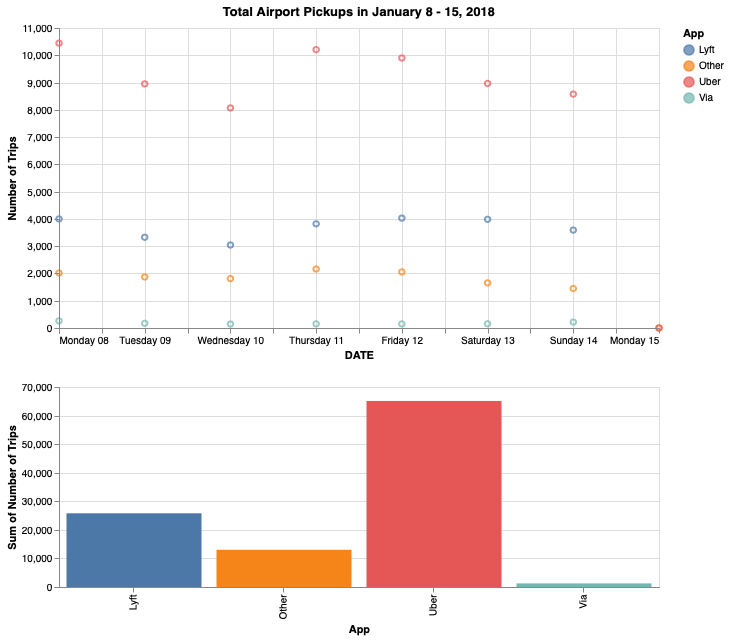

In [65]:
src = overall_byApp
size_selector = alt.selection_multi(encodings=['x'])

scatter = alt.Chart(src, 
                    title="Total Airport Pickups in January 8 - 15, 2018", 
                    width=600).mark_point().encode(alt.X("Day:T"
                             , axis = alt.Axis(title = 'Date'.upper(), format = ("%A %d"))
                             ),
    y="Number of Trips:Q",
    color = alt.condition( size_selector , "App:N", alt.value("white")), 
    tooltip=('App', 'Number of Trips')
).add_selection(size_selector)

size_hist = alt.Chart(src, width=600, height=200).mark_bar().encode(
    alt.X("App:N"            
        , sort=alt.EncodingSortField(
        field="sum(Number of Trips)",  # The field to use for the sort
        order="ascending"  # The order to sort in
        )
        ),
    y = "sum(Number of Trips):Q",
    color = alt.condition(size_selector, 'App:N', alt.value("lightgray")),
    tooltip = (alt.Tooltip('sum(Number of Trips)', title='Total Count for {}'.format(src['App'])))
).add_selection(size_selector) #this binds the selector to the plot

scatter & size_hist

### Shared Trips

We will use the SR_flag column to filter the trip records for shared trips only.

In [9]:
trips_airport_shared = trips_airport[trips_airport['SR_Flag']==1]

In [27]:
trips_airport_shared = trips_airport_shared[['dispatching_base_number', 'Pickup_DateTime', 'PUlocationID', 'SR_Flag']]

In [31]:
trips_airport_shared = trips_airport_shared.merge(for_hire_app, left_on='dispatching_base_number', right_on='Base Number', how='left')

In [32]:
sharedByApp = trips_airport_shared[['Pickup_DateTime', 'App', 'Base Number']]

In [33]:
sharedByApp['Count']=1

/Users/fannyshum/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [34]:
sharedByApp['Day'] = pd.DatetimeIndex(sharedByApp['Pickup_DateTime']).strftime("%m/%d/%Y")

/Users/fannyshum/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [35]:
sharedByApp_sum = sharedByApp[['App', 'Day', 'Count']]

In [36]:
sharedByApp_sum = sharedByApp_sum.groupby(['App', 'Day']).sum()
sharedByApp_sum = sharedByApp_sum.reset_index()

For a quick overview of shared trips by company:

In [37]:
sharedByApp_total = sharedByApp_sum[['App', 'Count']]
sharedByApp_total = sharedByApp_total.groupby('App').sum()
sharedByApp_total

,Count
App,
Lyft,7481
Other,644
Uber,5640
Via,268


#### Visualization

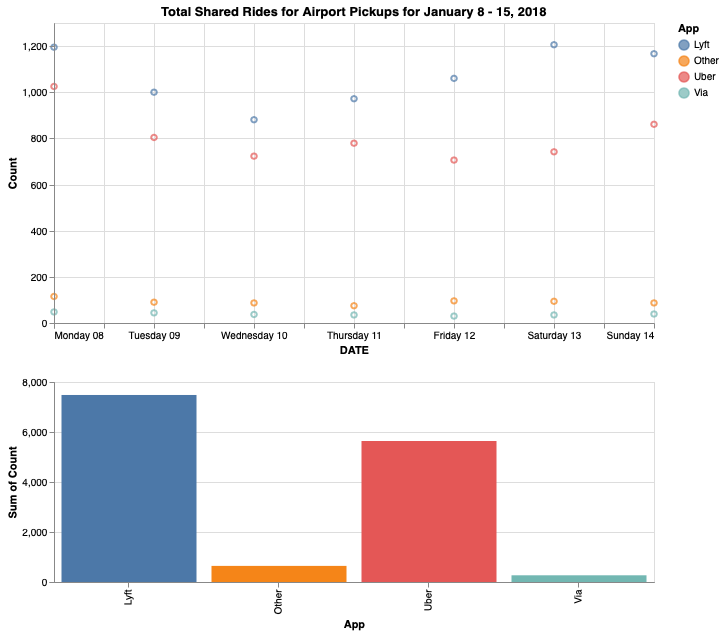

In [42]:
src = sharedByApp_sum
size_selector = alt.selection_multi(encodings=['x'])

scatter = alt.Chart(src, 
                    title="Total Shared Rides for Airport Pickups for January 8 - 15, 2018", 
                    width=600).mark_point().encode(alt.X("Day:T"
                             , axis = alt.Axis(title = 'Date'.upper(), format = ("%A %d"))
                             ),
    y="Count:Q",
    color = alt.condition( size_selector , "App:N", alt.value("white")), 
    tooltip=('App', 'Count')
).add_selection(size_selector)

#we input certain strings as functions
size_hist = alt.Chart(src, width=600, height=200).mark_bar().encode(
    alt.X("App:N"            
        ),
    y = "sum(Count):Q",
    color = alt.condition(size_selector, 'App:N', alt.value("lightgray")),
    tooltip = (alt.Tooltip('sum(Count)', title='Total Count for {}'.format(src['App'])))
).add_selection(size_selector) #this binds the selector to the plot


scatter & size_hist

### WAV

We will use the column Wheelchair Accessible in the Active For-Hire Vehicles to identify the number of WAV vehicles. Since the 2018 Trip Records only provides the Base Number of the vehicle (and no license number), we will have to approximate the number of WAV vehicles for the airpot trips. For the approximation, we will use the percentage of all WAV vehicles for each corresponding Base Number to scale the total number of airport trips. In otherwords, we if company A has 20% WAV out of all its vehicles, then there is a fair chance that approximately 20% of the vehicles used for the airport trips are also WAV.

In [38]:
for_hire_WAV = for_hire_filtered[for_hire_filtered['Wheelchair Accessible']=='WAV']

In [39]:
for_hire_WAV_Ct = for_hire_WAV[['Base Number', 'App', 'Wheelchair Accessible']]

In [40]:
for_hire_WAV_Ct = for_hire_WAV_Ct.groupby(['Base Number', 'App']).count()
for_hire_WAV_Ct = for_hire_WAV_Ct.reset_index()

In [45]:
for_hire_WAVratio = for_hire_Ct.merge(for_hire_WAV_Ct, on=['App', 'Base Number'], how='left')

In [46]:
for_hire_WAVratio = for_hire_WAVratio.fillna(0)

In [47]:
for_hire_WAVratio['% WAV'] = for_hire_WAVratio['Wheelchair Accessible']/for_hire_WAVratio['Total Vehicles']

In [48]:
for_hire_WAVratio = for_hire_WAVratio[['App', 'Base Number', '% WAV']]

#### Implement the WAV scale in the 2018 Trip records

In [51]:
WAV_Ct = trips_airport[['dispatching_base_number', 'Day']]

In [52]:
WAV_Ct['Number of Trips'] = 1

/Users/fannyshum/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [53]:
WAV_Ct = WAV_Ct.groupby(['dispatching_base_number', 'Day']).sum()

In [54]:
WAV_Ct = WAV_Ct.reset_index()

In [55]:
WAV_Ct = WAV_Ct.merge(for_hire_WAVratio, left_on = 'dispatching_base_number', right_on = 'Base Number', how='left')

In [56]:
WAV_Ct = WAV_Ct[['App', 'dispatching_base_number', 'Day', '% WAV', 'Number of Trips']]
WAV_Ct.columns = ['App', 'Base Number', 'Day', '% WAV', 'Number of Trips']

In [57]:
WAV_Ct['Approx WAVs'] = WAV_Ct['% WAV']*WAV_Ct['Number of Trips']

In [58]:
Approx_WAV = WAV_Ct[['App', 'Day', 'Approx WAVs']]
Approx_WAV = Approx_WAV.groupby(['App', 'Day']).sum()
Approx_WAV = Approx_WAV.reset_index()

#### Visualization

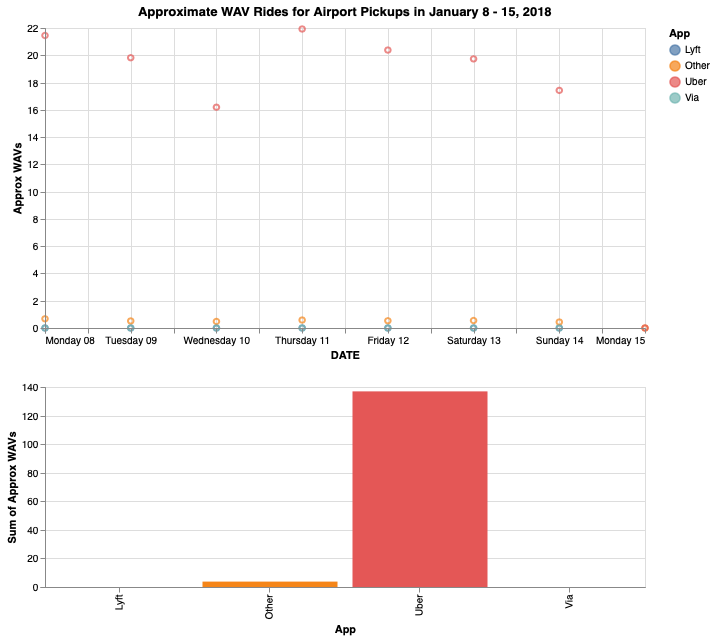

In [59]:
src = Approx_WAV
size_selector = alt.selection_multi(encodings=['x'])

scatter = alt.Chart(src, 
                    title="Approximate WAV Rides for Airport Pickups in January 8 - 15, 2018", 
                    width=600).mark_point().encode(alt.X("Day:T"
                             , axis = alt.Axis(title = 'Date'.upper(), format = ("%A %d"))
                             ),
    y="Approx WAVs:Q",
    color = alt.condition( size_selector , "App:N", alt.value("white")), 
    tooltip=('App', 'Approx WAVs')
).add_selection(size_selector)


size_hist = alt.Chart(src, width=600, height=200).mark_bar().encode(
    alt.X("App:N"            
        ),
    y = "sum(Approx WAVs):Q",
    color = alt.condition(size_selector, 'App:N', alt.value("lightgray")),
    tooltip = (alt.Tooltip('sum(Approx WAVs)', title='Total Count for {}'.format(src['App'])))
).add_selection(size_selector) #this binds the selector to the plot

scatter & size_hist

### BEV

To identify the BEV, we will use the Vehicle Vin Number column in the Active For-Hire Vehicles in the NHTSA Vehicle API (https://vpic.nhtsa.dot.gov/api/). If the primary fuel type column is electric and the secondary fuel typ column is empty, then the corresponding vehicle is electric.

#### Attempt One
We will create a for-loop to read feed each VIN into the API. Unfortunately, there are too many VINs and it took about 2 hours to successfully decode approximately 5000 VINs. Since there are approximately 85,000 VINs, that would've taken almost a day to keep running, while it kept losing connection after a few batches. Below is the script:

In [ ]:
test = for_hire_filtered[['Vehicle VIN Number', 'Base Number', 'App', 'VEH', 'Vehicle Year']]
df = pd.read_csv('https://vpic.nhtsa.dot.gov/api/vehicles/DecodeVinValues/{}?format=csv&modelyear={}'.
                 format(test.iloc[0]['Vehicle VIN Number'], test.iloc[0]['Vehicle Year']))

for i in range(1, len(test)):
    vin = test.iloc[i]['Vehicle VIN Number']
    yr = test.iloc[i]['Vehicle Year']
    df1 = pd.read_csv('https://vpic.nhtsa.dot.gov/api/vehicles/DecodeVinValues/{}?format=csv&modelyear={}'.format(vin, yr))
    df = df.append(df1)

#### Attempt Two
We will attempt to use the built-in Decode VIN (flat format) in a Batch to decode all VINs. All VINs are extracted as one string and fed into the Batch decoder. Unfortunately, due to the  number of VINs, the built-in decoder would also lose its connection trying to process all the VINs.

In [ ]:
vin_feed_str = ''
for i in range(len(test)):
    vin = test.iloc[i]['Vehicle VIN Number']
    vin_feed_str += '{}; '.format(vin)

#### Attempt Three
Since the For-Hire Vehicle data has a VEH column indicating BEV vehicles, we verified the validity of the column with the data we did recover from Attempt One and those with the BEV indicator. The test DataFrame gathered from Attempt One has no BEV follwing the guideline provided. We cross-referenced the VINs in test with the VINs in For-Hire Vehicle (BEV) and found no overlap. Then we fed the VINs in For-Hire Vehicle (BEV) and verfied that they are indeed BEV following the guideline. So we will use the For-Hire Vehicle (BEV) to approximate the number of BEVs.

In [73]:
df = pd.read_csv('test.csv')

/Users/fannyshum/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3057: DtypeWarning: Columns (7,49,50,51,52,60,61,63,66,110,123) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [74]:
electric_draft = df[df['fueltypeprimary'] == 'Electric']

In [75]:
# Compare with BEV mark
bev_mark = for_hire_filtered[for_hire_filtered['VEH']=='BEV']

In [77]:
bev_check = electric_draft.merge(bev_mark, left_on='vin', right_on='Vehicle VIN Number', how='outer', indicator=True)

In [78]:
bev_check[['vin', 'Vehicle VIN Number', 'Base Number', '_merge']]

,vin,Vehicle VIN Number,Base Number,_merge
0,4T1BD1EB1JU061411,NaN,NaN,left_only
1,5TDDGRFH3HS030066,NaN,NaN,left_only
2,4T1BD1EBXJU060404,NaN,NaN,left_only
3,JTDKN3DP7C3027041,NaN,NaN,left_only
4,JTMRJREV6JD258319,NaN,NaN,left_only
5,5TDJGRFH8JS040102,NaN,NaN,left_only
6,5TDDGRFH5HS035902,NaN,NaN,left_only
7,1FADP5CU8EL521620,NaN,NaN,left_only
8,5TDJGRFH7HS029389,NaN,NaN,left_only
9,5TDJGRFH1KS059396,NaN,NaN,left_only


In [79]:
bev_check[['vin', 'Vehicle VIN Number', 'Base Number', '_merge']][bev_check['_merge']=='both']

,vin,Vehicle VIN Number,Base Number,_merge


Check For-Hire Vehicle BEV are electric in the API.

In [80]:
bev_mark_vin = ''
for i in range(len(bev_mark)):
    vin = bev_mark.iloc[i]['Vehicle VIN Number']
    bev_mark_vin += '{}; '.format(vin)

In [81]:
vin_check_2 = pd.read_csv('VINValuesBatch-2.csv')

In [82]:
vin_check_2[['vin', 'fueltypeprimary', 'fueltypesecondary']]

,vin,fueltypeprimary,fueltypesecondary
0,5YJXCBE25GF004231,Electric,NaN
1,5YJ3E1EB0KF441775,Electric,NaN
2,5YJ3E1EBXKF510620,Electric,NaN
3,5YJSA1E21JF234236,Electric,NaN
4,5YJ3E1EA1KF464747,Electric,NaN
5,1N4AZ1CP3KC306741,Electric,NaN
6,1G1FY6S02K4127825,Electric,NaN
7,5YJSA1E20JF266675,Electric,NaN
8,5YJ3E1EB8KF451454,Electric,NaN
9,KM8K23AGXKU051819,Electric,NaN


#### BEV Count

In [92]:
for_hire_BEV_Ct = bev_mark[['App', 'Base Number', 'VEH']]
for_hire_BEV_Ct = for_hire_BEV_Ct.groupby(['App', 'Base Number']).count()
for_hire_BEV_Ct = for_hire_BEV_Ct.reset_index()

In [93]:
for_hire_BEV_Ct.columns = ['App', 'Base Number', 'BEV']

In [94]:
for_hire_BEVratio = for_hire_Ct.merge(for_hire_BEV_Ct, on=['App', 'Base Number'], how='left')
for_hire_BEVratio = for_hire_BEVratio.fillna(0)
for_hire_BEVratio['% BEV'] = for_hire_BEVratio['BEV']/for_hire_BEVratio['Total Vehicles']
for_hire_BEVratio = for_hire_BEVratio[['App', 'Base Number', '% BEV']]

In [95]:
BEV_Ct = trips_airport[['dispatching_base_number', 'Day']]
BEV_Ct['Number of Trips'] = 1

/Users/fannyshum/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [97]:
BEV_Ct = BEV_Ct.groupby(['dispatching_base_number', 'Day']).sum()
BEV_Ct = BEV_Ct.reset_index()

In [98]:
BEV_Ct = BEV_Ct.groupby(['dispatching_base_number', 'Day']).sum()
BEV_Ct = BEV_Ct.reset_index()
BEV_Ct = BEV_Ct.merge(for_hire_BEVratio, left_on = 'dispatching_base_number', right_on = 'Base Number', how='left')
BEV_Ct = BEV_Ct[['App', 'dispatching_base_number', 'Day', '% BEV', 'Number of Trips']]
BEV_Ct.columns = ['App', 'Base Number', 'Day', '% BEV', 'Number of Trips']
BEV_Ct['Approx BEVs'] = BEV_Ct['% BEV']*BEV_Ct['Number of Trips']

In [100]:
Approx_BEV = BEV_Ct[['App', 'Day', 'Approx BEVs']]
Approx_BEV = Approx_BEV.groupby(['App', 'Day']).sum()
Approx_BEV = Approx_BEV.reset_index()

#### Visualization

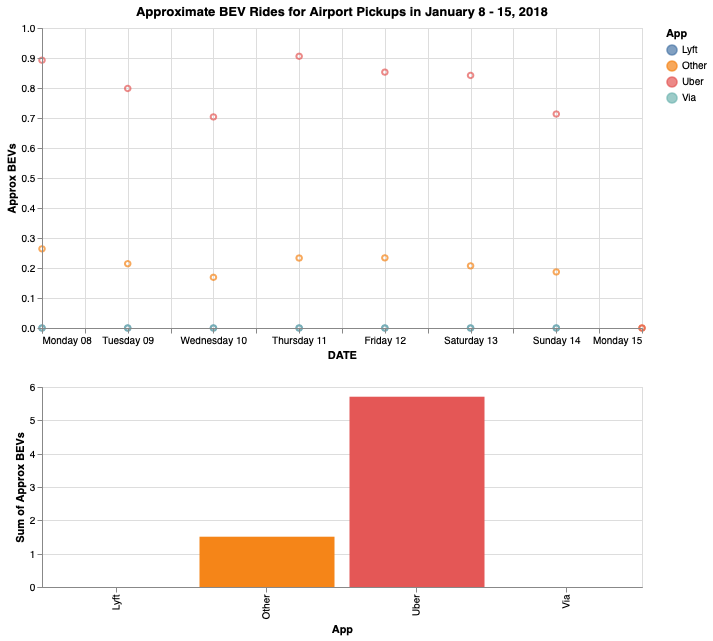

In [102]:
src = Approx_BEV
size_selector = alt.selection_multi(encodings=['x'])

scatter = alt.Chart(src, 
                    title="Approximate BEV Rides for Airport Pickups in January 8 - 15, 2018", 
                    width=600).mark_point().encode(alt.X("Day:T"
                             , axis = alt.Axis(title = 'Date'.upper(), format = ("%A %d"))
                             ),
    y="Approx BEVs:Q",
    color = alt.condition( size_selector , "App:N", alt.value("white")), 
    tooltip=('App', 'Approx BEVs')
).add_selection(size_selector)


size_hist = alt.Chart(src, width=600, height=200).mark_bar().encode(
    alt.X("App:N"            
        ),
    y = "sum(Approx BEVs):Q",
    color = alt.condition(size_selector, 'App:N', alt.value("lightgray")),
    tooltip = (alt.Tooltip('sum(Approx BEVs)', title='Total Count for {}'.format(src['App'])))
).add_selection(size_selector) #this binds the selector to the plot

scatter & size_hist

## Merge Into One DataFrame

In [66]:
sharedByApp_sum.columns = ['App', 'Day', 'Shared Trips']

In [68]:
trip_summary = overall_byApp.merge(sharedByApp_sum, on=['App', 'Day'], how='left')

In [69]:
trip_summary = trip_summary.fillna(0)
trip_summary['Shared Trips'] = trip_summary['Shared Trips'].astype(int)

In [70]:
trip_summary['% Shared'] = round(trip_summary['Shared Trips']/trip_summary['Number of Trips'], 3)

In [71]:
trip_summary = trip_summary.merge(Approx_WAV, on=['App', 'Day'], how='left')

In [72]:
trip_summary = trip_summary.fillna(0)
trip_summary['Approx WAVs'] = round(trip_summary['Approx WAVs'], 1)
trip_summary['% Approx WAVs'] = round(trip_summary['Approx WAVs']/trip_summary['Number of Trips'], 3)

In [103]:
trip_summary = trip_summary.merge(Approx_BEV, on=['App', 'Day'], how='left')

In [104]:
trip_summary = trip_summary.fillna(0)
trip_summary['Approx BEVs'] = round(trip_summary['Approx BEVs'], 1)
trip_summary['% Approx BEVs'] = round(trip_summary['Approx BEVs']/trip_summary['Number of Trips'], 3)

In [105]:
trip_summary

,App,Day,Number of Trips,Shared Trips,% Shared,Approx WAVs,% Approx WAVs,Approx BEVs,% Approx BEVs
0,Lyft,01/08/2018,4001,1195,0.299,0.0,0.000,0.0,0.0
1,Lyft,01/09/2018,3326,1000,0.301,0.0,0.000,0.0,0.0
2,Lyft,01/10/2018,3043,881,0.290,0.0,0.000,0.0,0.0
3,Lyft,01/11/2018,3821,972,0.254,0.0,0.000,0.0,0.0
4,Lyft,01/12/2018,4029,1060,0.263,0.0,0.000,0.0,0.0
5,Lyft,01/13/2018,3984,1206,0.303,0.0,0.000,0.0,0.0
6,Lyft,01/14/2018,3591,1167,0.325,0.0,0.000,0.0,0.0
7,Other,01/08/2018,2016,115,0.057,0.7,0.000,0.3,0.0
8,Other,01/09/2018,1872,90,0.048,0.5,0.000,0.2,0.0
9,Other,01/10/2018,1813,87,0.048,0.5,0.000,0.2,0.0


In [106]:
trip_summary.to_csv('trip_summary.csv')

## Task 2
Below is an example of a visualization that can be useful for a quick analysis of the day-by-day trend of shared trips, WAV trips, and BEV trips.

In [107]:
trip_type_1 = trip_summary[['Day', 'App', 'Shared Trips']]
trip_type_2 =trip_summary[['Day', 'App', 'Approx WAVs']]
trip_type_3 =trip_summary[['Day', 'App', 'Approx BEVs']]

In [111]:
trip_type_1.columns = [ 'Day', 'App','Count']
trip_type_2.columns = ['Day', 'App','Count']
trip_type_3.columns = [ 'Day', 'App','Count']

In [109]:
App = ['Uber', 'Lyft', 'Via', 'Juno', 'Other']

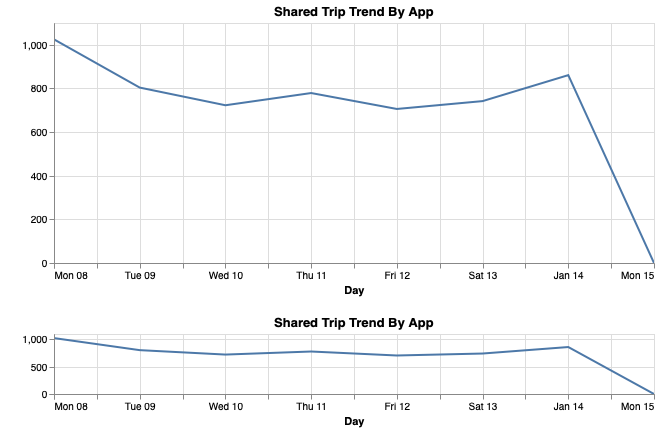

In [112]:
src = trip_type_1
brush = alt.selection(type='interval', encodings=['x'], clear=False)

base = alt.Chart(src, title="Shared Trip Trend By App").mark_line().encode(
    alt.X('Day:T', scale=alt.Scale(domain=brush)),
    alt.Y('Count', title=" ")
)

columns=App

# A dropdown filter
column_dropdown = alt.binding_select(options=columns)
column_select = alt.selection_single(
    fields=['App'],
    on='doubleclick',
    clear=False, 
    bind=column_dropdown, 
    name="Company",
    init={'App': "Uber"}
)


#Specify the top chart as a modification of the base chart
filter_columns = base.add_selection(
    column_select
).transform_filter(
    column_select
).properties(
    height=240,
    width = 600
)


#Specify the lower chart as a modification of the base chart
lower = filter_columns.add_selection(
    column_select
).transform_filter(
    column_select
).properties(
    height=60,
    width = 600
).add_selection(brush)

filter_columns & lower